In [37]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score as r2

In [38]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(10,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [39]:
def less_quantile(df, quant, column):
    df.loc[df[column] < df[column].quantile(quant), column] = df[column].quantile(quant)
    return df

In [40]:
def more_quantile(df, quant, column):
    df.loc[df[column] > df[column].quantile(quant), column] = df[column].quantile(quant)
    return df

In [41]:
def fillna_replace(df_train, df, column1, column2):
    df[column1] = df[column1].fillna(df[column2] * (df_train[column1] / df_train[column2]).mean())
    return df

In [42]:
def replace_columns(df, column1, column2):
    df.loc[df[column1] > df[column2], [column1, column2]] = (df.loc[df[column1] > df[column2], [column2, column1]].values)
    return df

In [43]:
def more_less_replace_mean(df_train, df, column1, column2, num_l, num_r):
    med_sq_room = (df_train.loc[(df_train[column1] != 0), column2] / df_train.loc[(df_train[column1] != 0), column1]).mean()
    df.loc[(df[column1] == num_l) | (df[column1] > num_r), column1] = np.ceil(df.loc[(df[column1] == num_l) | (df[column1] > num_r), column2] / med_sq_room)
    return df

In [44]:
def replace_abs_med(df_train, df, column1, column2, column3, num_room, criteria):
    for i in range(1, num_room + 1):
        median = df_train.loc[(df_train[column1] == i), column2].median()
        df.loc[(np.absolute(df[column2] - df[column3]) > criteria) & (df[column1] == i), column2] = median
    return df

In [45]:
matplotlib.rcParams.update({'font.size': 14})

In [46]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [47]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Анализ данных

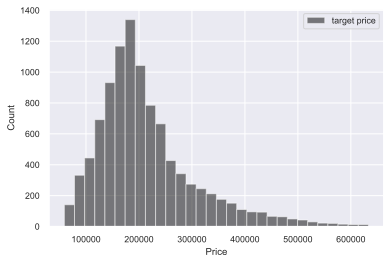

In [48]:
plt.hist(train_data['Price'], bins=30, alpha=.5, color='black', label='target price')
plt.legend(loc='upper right')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()

In [49]:
train_data.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [50]:
train_data.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962
5,5804,99,3.0,62.528465,47.103833,6.0,9,9.0,1972,0.012339,B,B,35,5776,1,2078.0,2,4,B,161044.944138
6,8864,44,1.0,33.938750,21.772930,9.0,1,12.0,1968,0.232205,B,B,24,4860,1,80.0,0,3,B,142402.739272
7,13072,59,2.0,50.391814,32.893256,8.0,8,17.0,1986,0.019509,B,B,37,7687,11,176.0,5,5,B,326174.175191
8,9951,1,1.0,46.887892,44.628132,1.0,12,20.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,160400.401732
9,8094,6,3.0,79.867477,75.085125,1.0,3,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,194756.023945


Перед обработкой данных разделим датасет train на тренировочный и валидационный для дальнейшей минимизации переобучения модели. При замене значений в валидационном датасете будем использовать соотвутствующие значения из train

In [51]:
x = train_data.drop(columns='Price')
y = train_data['Price']
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.35, shuffle=True, random_state=42)

Ограничим значения в столбце Square квантилями слева .01% и справа .999% и заменим соответствующими значениями

In [52]:
x_train = less_quantile(x_train, .01, 'Square')
x_valid = less_quantile(x_valid, .01, 'Square')
test_data = less_quantile(test_data, .01, 'Square')

In [53]:
x_train = more_quantile(x_train, .999, 'Square')
x_valid = more_quantile(x_valid, .999, 'Square')
test_data = more_quantile(test_data, .999, 'Square')

Пустые значения в столбце LifeSquare заменим средним процентным отношением общей площади квартиры к жилой площади

In [54]:
x_train = fillna_replace(x_train, x_train, 'LifeSquare', 'Square')
x_valid = fillna_replace(x_train, x_valid, 'LifeSquare', 'Square')
test_data = fillna_replace(test_data, x_train, 'LifeSquare', 'Square')

Значения в столбце LifeSquare по смыслу не могут быть больше, чем значения в столбце Square, в противном случае поменяем местами значения

In [55]:
x_train = replace_columns(x_train, 'LifeSquare', 'Square')
x_valid = replace_columns(x_valid, 'LifeSquare', 'Square')
test_data = replace_columns(test_data, 'LifeSquare', 'Square')

Значения в столбце KitchenSquare, которые меньше 5, заменим на 0, полагая, что 0 - это кухня-гостиная (далее добавим дополнительный признак евро-планировка)

In [56]:
x_train.loc[(x_train['KitchenSquare'] < 5), 'KitchenSquare'] = 0
x_valid.loc[(x_valid['KitchenSquare'] < 5), 'KitchenSquare'] = 0
test_data.loc[(test_data['KitchenSquare'] < 5), 'KitchenSquare'] = 0

Значения в столбце Rooms равные 0 или больше 6 заменим отношением общей площади квартиры к среднему метражу однокомнатной квартиры датасета train с последующим округлением вверх до целого

In [57]:
x_train = more_less_replace_mean(x_train, x_train, 'Rooms', 'Square', 0, 6)
x_valid = more_less_replace_mean(x_train, x_valid, 'Rooms', 'Square', 0, 6)
test_data = more_less_replace_mean(test_data, test_data, 'Rooms', 'Square', 0, 6)

In [58]:
x_train['Rooms'].value_counts()

2.0    2517
1.0    2427
3.0    1448
4.0      98
5.0      10
Name: Rooms, dtype: int64

In [59]:
x_valid['Rooms'].value_counts()

2.0    1369
1.0    1279
3.0     789
4.0      52
5.0       9
6.0       1
7.0       1
Name: Rooms, dtype: int64

In [60]:
test_data['Rooms'].value_counts()

2.0    2517
1.0    2427
3.0    1448
4.0      98
5.0      10
Name: Rooms, dtype: int64

Значения в столбце LifeSquare, если |Square-LifeSquare| > 100, заменим на медиану LifeSquare для данного количества комнат

In [61]:
x_train = replace_abs_med(x_train, x_train, 'Rooms', 'LifeSquare', 'Square', 5, 100)
x_valid = replace_abs_med(x_train, x_valid, 'Rooms', 'LifeSquare', 'Square', 5, 100)
test_data = replace_abs_med(test_data, test_data, 'Rooms', 'LifeSquare', 'Square', 5, 100)

Ограничим значения в столбце KitchenSquare квантилями справа .99% и заменим соответствующими значениями

In [62]:
x_train = more_quantile(x_train, .99, 'KitchenSquare')
x_valid = more_quantile(x_valid, .99, 'KitchenSquare')
test_data = more_quantile(test_data, .99, 'KitchenSquare')

Значения в столбце HouseFloor равные 0 заменим на соответствующие значения Floor. Значения в столбце Floor по смыслу не могут быть больше, чем значения в столбце HouseFloor, в противном случае поменяем местами значения

In [63]:
x_train.loc[(x_train['HouseFloor'] == 0), 'HouseFloor'] = x_train.loc[(x_train['HouseFloor'] == 0), 'Floor']
x_valid.loc[(x_valid['HouseFloor'] == 0), 'HouseFloor'] = x_valid.loc[(x_valid['HouseFloor'] == 0), 'Floor']
test_data.loc[(test_data['HouseFloor'] == 0), 'HouseFloor'] = test_data.loc[(test_data['HouseFloor'] == 0), 'Floor']

In [64]:
x_train = replace_columns(x_train, 'Floor', 'HouseFloor')
x_valid = replace_columns(x_valid, 'Floor', 'HouseFloor')
test_data = replace_columns(test_data, 'Floor', 'HouseFloor')

Значения в столбце HouseYear больше 2022 заменим на 2022

In [65]:
x_train.loc[(x_train['HouseYear'] > 2022), 'HouseYear'] = 2022
x_valid.loc[(x_valid['HouseYear'] > 2022), 'HouseYear'] = 2022
test_data.loc[(test_data['HouseYear'] > 2022), 'HouseYear'] = 2022

Приведем строковые признаки Ecology_2, Ecology_3 и Shops_2 к числовым путем бинарной замены

In [66]:
x_train['Ecology_2_int'] = x_train['Ecology_2'].replace({'A':0, 'B':1})
x_train['Ecology_3_int'] = x_train['Ecology_3'].replace({'A':0, 'B':1})
x_train['Shops_2_int'] = x_train['Shops_2'].replace({'A':0, 'B':1})
x_valid['Ecology_2_int'] = x_valid['Ecology_2'].replace({'A':0, 'B':1})
x_valid['Ecology_3_int'] = x_valid['Ecology_3'].replace({'A':0, 'B':1})
x_valid['Shops_2_int'] = x_valid['Shops_2'].replace({'A':0, 'B':1})
test_data['Ecology_2_int'] = test_data['Ecology_2'].replace({'A':0, 'B':1})
test_data['Ecology_3_int'] = test_data['Ecology_3'].replace({'A':0, 'B':1})
test_data['Shops_2_int'] = test_data['Shops_2'].replace({'A':0, 'B':1})

Добавим новый признак евро-планировка. После анализа данных в датасете определим влияние данного признака на целевую переменную

In [67]:
x_train['Euro'] = 0
x_valid['Euro'] = 0
test_data['Euro'] = 0
x_train.loc[(x_train['KitchenSquare'] == 0), 'Euro'] = 1
x_valid.loc[(x_valid['KitchenSquare'] == 0), 'Euro'] = 1
test_data.loc[(test_data['KitchenSquare'] == 0), 'Euro'] = 1

Значения в столбце Healthcare_1 равные 0 или NaN заменим на медиану датасета train

In [68]:
x_train.loc[(x_train['Healthcare_1'] == 0) | x_train['Healthcare_1'].isna(), 'Healthcare_1'] = x_train['Healthcare_1'].median()
x_valid.loc[(x_valid['Healthcare_1'] == 0) | x_valid['Healthcare_1'].isna(), 'Healthcare_1'] = x_train['Healthcare_1'].median()
test_data.loc[(test_data['Healthcare_1'] == 0) | test_data['Healthcare_1'].isna(), 'Healthcare_1'] = test_data['Healthcare_1'].median()

Проанализируем влияние признаков на целевую переменную, для этого построим матрицу корреляции

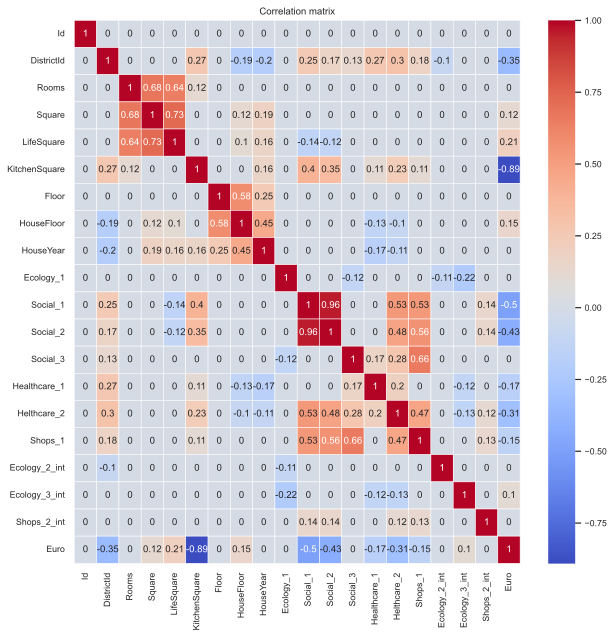

In [69]:
plt.figure(figsize = (10,10))
sns.set(font_scale=.8)
x_train_corr = x_train.corr()
x_train_corr = np.round(x_train_corr, 2)
x_train_corr[np.abs(x_train_corr) < 0.1] = 0
sns.heatmap(x_train_corr, annot=True, linewidths=.5, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

Обучение модели

In [70]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_int']
x_train = pd.DataFrame(x_train, columns=feature_names)
x_valid = pd.DataFrame(x_valid, columns=feature_names)

In [71]:
model = RandomForestRegressor(n_estimators = 1000, max_depth = 12, random_state = 42)
model.fit(x_train, y_train)

RandomForestRegressor(max_depth=12, n_estimators=1000, random_state=42)

Train R2:	0.899
Test R2:	0.71


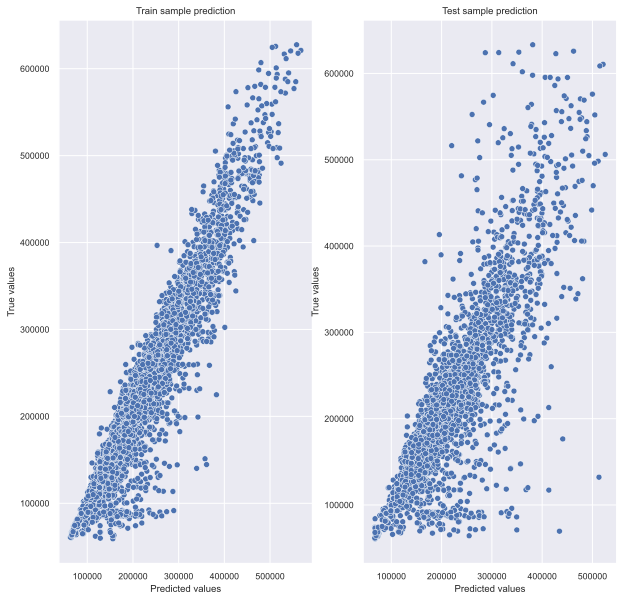

In [72]:
y_train_preds = model.predict(x_train)
y_valid_preds = model.predict(x_valid)
evaluate_preds(y_train, y_train_preds, y_valid, y_valid_preds)


Прогноз на тестовом датасете test_data

In [664]:
test_data = pd.DataFrame(test_data, columns=feature_names)
y_test_data_preds = model.predict(test_data)

In [665]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission['Price'] = y_test_data_preds
sample_submission.to_csv('my_submit.csv', index=False)